In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import scanpy as sc
import numpy as np

import scvelo as scv

from scprotvelo._data_processing import pair_data

import warnings
warnings.filterwarnings("ignore")

# Prepare Paired Data

In [3]:
BASE_PATH = '/home/icb/sabrina.richter/git/scprotvelo/data/'

DATA_PATH = f'{BASE_PATH}data_raw/'
DATA_PATH_OUT = f'{BASE_PATH}data_paired/'

## Computationally Paired mRNA-Protein for scProtVelo and corresponding data for veloVI

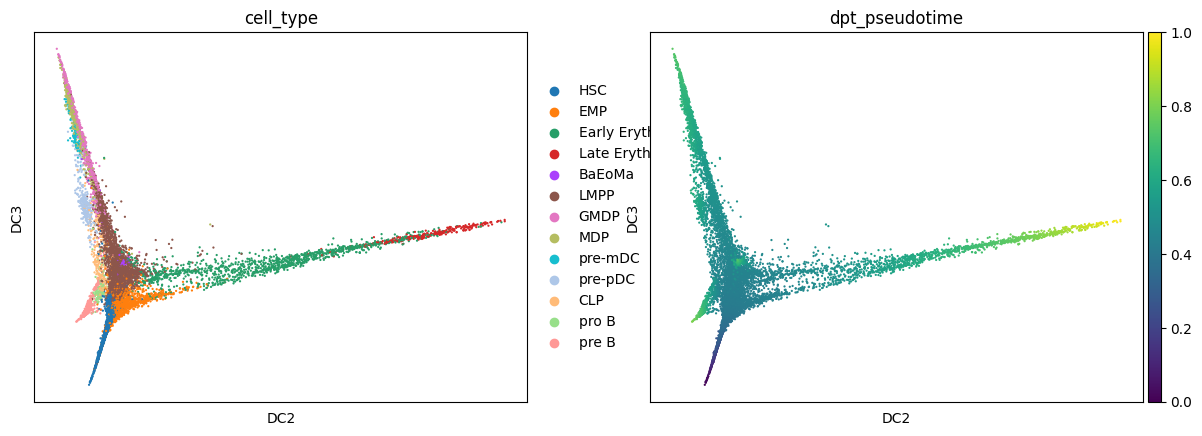

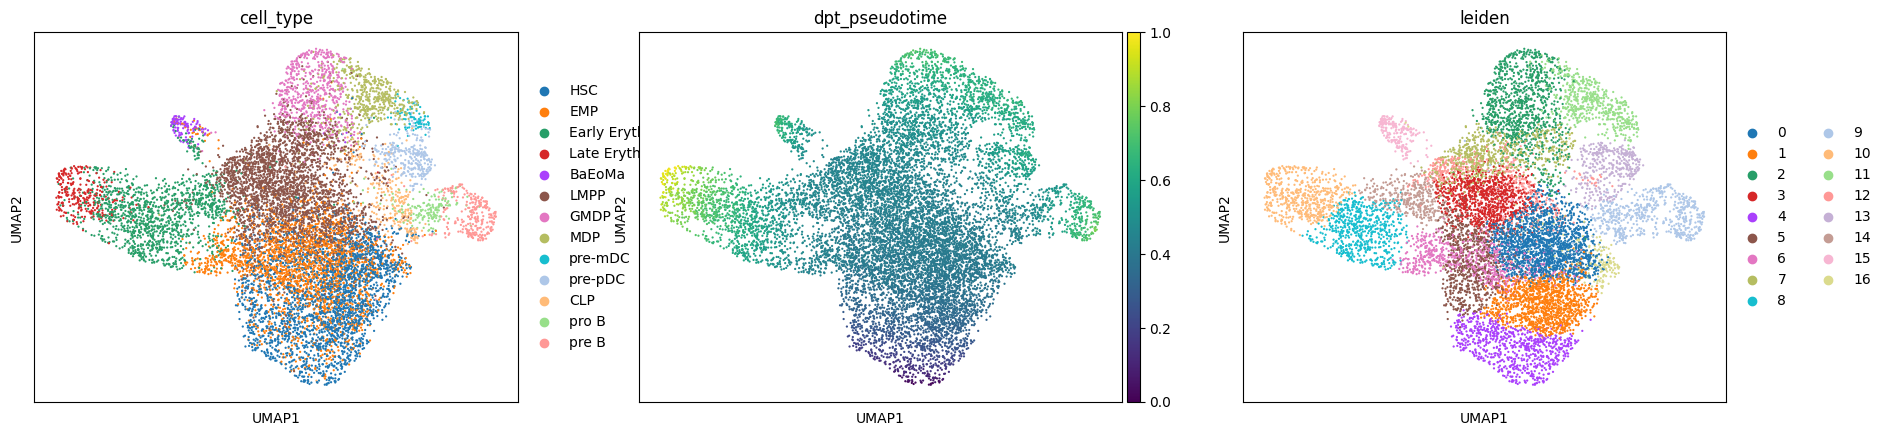

In [4]:
combined = sc.read_h5ad(f'{DATA_PATH}combined_without_layers.h5ad')

# compute diffusion pseudotime on GLUE embedding
m = np.argmin(combined.obsm['X_diffmap'][:, 2])
combined.uns['iroot'] = m
m = combined.obs.index[m]
combined.obs['xroot'] = 0
combined.obs.loc[m, 'xroot'] = 1
sc.tl.dpt(combined)
del combined.uns['iroot']
sc.pl.diffmap(combined, components=['2,3'], color=['cell_type', 'dpt_pseudotime'])

# compute leiden clustering on GLUE embedding
sc.tl.leiden(combined)
sc.pl.umap(combined, color=['cell_type', 'dpt_pseudotime', 'leiden'])

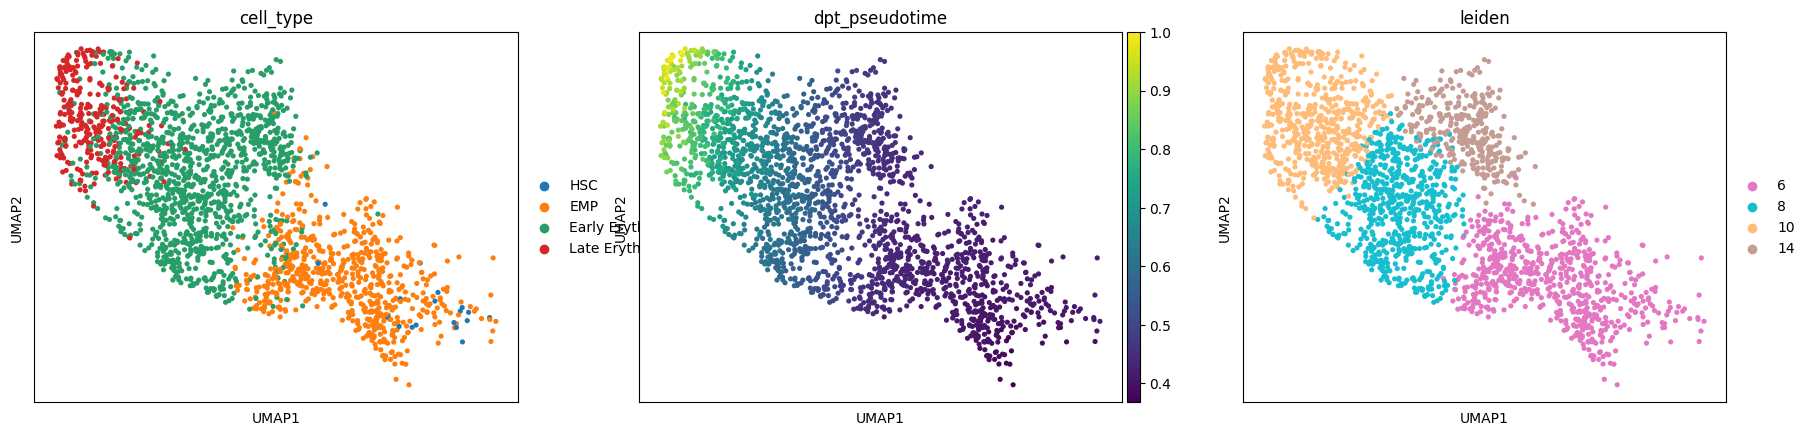

proteins after filtering for 30% completeness: 1065
mRNAs after filtering for 2% completeness: 5101
intersection: 1036

protein: 472 cells
rna: 1677 cells

146 DE genes selected:
['PRKDC', 'SPTBN1', 'AHNAK', 'ANXA6', 'CLTC', 'HSPA8', 'LMNB1', 'HSP90AA1', 'VIM', 'PKM', 'NCL', 'LRPPRC', 'VCL', 'DHX9', 'HSPA9', 'MTHFD1', 'TUBB4B', 'MCM7', 'HSPD1', 'TUBB', 'MCM6', 'CCT2', 'CCT3', 'CCT5', 'CCT7', 'ATP5F1A', 'ANXA1', 'TCP1', 'NASP', 'IMMT', 'SF3B3', 'SERPINB1', 'DDX21', 'HMGB2', 'H2AFY', 'ATIC', 'SSB', 'RPL4', 'CORO1A', 'FKBP4', 'FSCN1', 'PPIA', 'PTPN6', 'PDCD4', 'TPM4', 'IMPDH2', 'NOP56', 'ANXA4', 'LRRFIP1', 'AHCY', 'CA1', 'ALDH1A1', 'HNRNPF', 'PAICS', 'LDHA', 'EIF5A', 'PCBP1', 'YBX1', 'ANXA5', 'PCNA', 'SERBP1', 'LMNA', 'ELMO1', 'ARHGDIB', 'ETFB', 'FBL', 'H1FX', 'NOLC1', 'TAF15', 'CAPG', 'PHB', 'EIF3I', 'PSMA3', 'IPO5', 'PRDX2', 'EFHD2', 'HPRT1', 'HMGN2', 'RPL8', 'AKR1C3', 'CACYBP', 'DDAH2', 'BLVRB', 'RAN', 'PSMA4', 'RAC2', 'PDAP1', 'GMFG', 'PABPC4', 'DLD', 'HSPE1', 'PSMB8', 'ALYREF', 'CTBP

In [5]:
cluster_list = ['10', '8', '14', '6']

# pair modalities by interpolating the missing modality over the GLUE embedding
adata, rna, prot = pair_data(
    data_path=DATA_PATH,
    data_path_out=DATA_PATH_OUT,
    combined=combined,
    cluster_list=cluster_list,
    file_name='paired_adata_Eryth',
    fractions=.3,
    n_cells=50,
    log_fc_prot=.1,
    log_fc_rna=.5,
    keep_cts=['HSC', 'EMP', 'Early Eryth', 'Late Eryth'],
)

In [6]:
# load unspliced/spliced data
bdatas = []
for p in ['old1', 'old2', 'young1', 'young2']:
    print(p)
    ldata = scv.read(f'{DATA_PATH}/cnt_{p.capitalize()}.loom')
    ldata.obs_names = [f'{o.split(":")[1][:-1]}-1-{p}' for o in ldata.obs_names]
    ldata.var_names_make_unique()
    bdatas.append(ldata)
adata_rna = sc.concat(bdatas, axis=0)
adata_rna = adata_rna[[o for o in rna.obs_names if o in adata_rna.obs_names]].copy()

# transfer metadata
adata_rna.obs = combined.obs.loc[adata_rna.obs_names, :]
adata_rna.uns = combined.uns
adata_rna.obsm['X_totalVI'] = rna[adata_rna.obs_names].obsm['X_totalVI']
adata_rna.obsm['X_umap'] = rna[adata_rna.obs_names].obsm['X_umap']
adata_rna.obs['dpt_pseudotime'] = rna[adata_rna.obs_names].obs['dpt_pseudotime']

# remove unnecessary parts
del adata_rna.layers['ambiguous']
del adata_rna.layers['matrix']
adata_rna.obs = adata_rna.obs[['dpt_pseudotime', 'cell_type', 'domain']]
adata_rna.uns = {k: v for k, v in adata_rna.uns.items() if k in ['cell_type_colors', 'domain_colors']}

# write
adata_rna.write(f'{DATA_PATH_OUT}paired_adata_rna_eryth.h5ad')

old1
old2
young1
young2


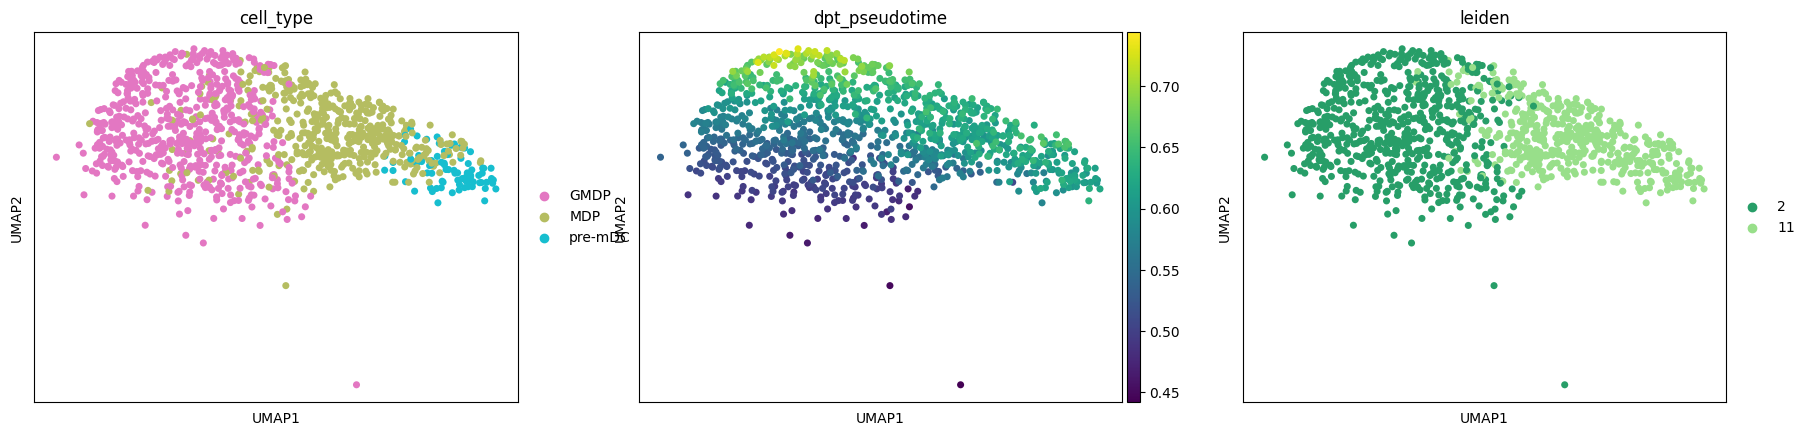

proteins after filtering for 30% completeness: 1101
mRNAs after filtering for 2% completeness: 5081
intersection: 1072

protein: 262 cells
rna: 897 cells

46 DE genes selected:
['FLNA', 'AHNAK', 'ANXA6', 'MPO', 'LCP1', 'VIM', 'IQGAP1', 'TUBB4B', 'CAT', 'EZR', 'CAP1', 'ANXA2', 'ACTB', 'SERPINB1', 'CORO1A', 'SAMHD1', 'HCLS1', 'ACTR3', 'CFL1', 'RNH1', 'GSN', 'CAPZB', 'ANXA5', 'ITGB2', 'ARPC2', 'PFKL', 'ZYX', 'LSP1', 'ALDH2', 'HEXB', 'MYL6', 'ERP29', 'ARPC1B', 'CDK6', 'FAM49B', 'S100A4', 'LYZ', 'LGALS1', 'HLA-DRB1', 'COTL1', 'TMSB4X', 'SH3BGRL3', 'GNAI3', 'PYCARD', 'S100A6', 'TIMM10']


In [7]:
cluster_list = ['2', '11']

# pair modalities by interpolating the missing modality over the GLUE embedding
adata, rna, prot = pair_data(
    data_path=DATA_PATH,
    data_path_out=DATA_PATH_OUT,
    combined=combined,
    cluster_list=cluster_list,
    file_name='paired_adata_premDC',
    fractions=.3,
    n_cells=50,
    log_fc_prot=.1,
    log_fc_rna=.5,
    recompute_pseudotime=True,
    dim_for_recompute_pseudotime=2,
    direction_for_recompute_pseudotime='min',
    keep_cts=['GMDP', 'MDP', 'pre-mDC'],
)

In [8]:
# load unspliced/spliced data
bdatas = []
for p in ['old1', 'old2', 'young1', 'young2']:
    print(p)
    ldata = scv.read(f'{DATA_PATH}/cnt_{p.capitalize()}.loom')
    ldata.obs_names = [f'{o.split(":")[1][:-1]}-1-{p}' for o in ldata.obs_names]
    ldata.var_names_make_unique()
    bdatas.append(ldata)
adata_rna = sc.concat(bdatas, axis=0)
adata_rna = adata_rna[[o for o in rna.obs_names if o in adata_rna.obs_names]].copy()

# transfer metadata
adata_rna.obs = combined.obs.loc[adata_rna.obs_names, :]
adata_rna.uns = combined.uns
adata_rna.obsm['X_totalVI'] = rna[adata_rna.obs_names].obsm['X_totalVI']
adata_rna.obsm['X_umap'] = rna[adata_rna.obs_names].obsm['X_umap']
adata_rna.obs['dpt_pseudotime'] = rna[adata_rna.obs_names].obs['dpt_pseudotime']

# remove unnecessary parts
del adata_rna.layers['ambiguous']
del adata_rna.layers['matrix']
adata_rna.obs = adata_rna.obs[['dpt_pseudotime', 'cell_type', 'domain']]
adata_rna.uns = {k: v for k, v in adata_rna.uns.items() if k in ['cell_type_colors', 'domain_colors']}

# write
adata_rna.write(f'{DATA_PATH_OUT}paired_adata_rna_premDC.h5ad')

old1
old2
young1
young2
